__Study the characteristics of the steel processing. For each key column value, find:__

 - The length of time between the first and the last temperature measurement.
 - The total heating time by the electrodes, that is, the sum of the values for all the intervals between the starts of the heating of the electrodes.
 - Number of starts of heating with electrodes.
 - Average ratio of active and reactive power consumption.  
 
For all the columns obtained, calculate the statistics: mean, minimum and maximum values, median and values of 25% and 75% quartiles.

__Изучить характеристики процесса обработки стали. Для каждого значения столбца key найти:__
 - [Длительность времени между первым и последним замером температуры.](#3)
 - [Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.](#2) 
 - [Количество запусков нагрева электродами.](#22) 
 - [Среднее соотношение потребления активной и реактивной мощности.](#4)

По всем полученным столбцам вычислить статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.


## Contents
  - [Preparing data](#11)
  - [Answers to Questions](#3)
      - [Duration of time between the first and the last temperature measurement.](#3)
      - [Accumulated heating time with electrodes.](#2)
      - [Number of starts for electrode heating.](#22)
      - [Average ratio of active and reactive power consumption.](#4)
## Содержание
 - [Подготовка данных](#11)
 - [Ответы на вопросы](#3)
     - [Длительность времени между первым и последним замером температуры.](#3)
     - [Суммарное время нагрева электродами.](#2) 
     - [Количество запусков нагрева электродами.](#22) 
     - [Среднее соотношение потребления активной и реактивной мощности.](#4)

In [1]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_arc = pd.read_csv("/app/_data/data_arc.csv")
data_temp = pd.read_csv("/app/_data/data_temp.csv")

<a id='11'></a>

# Preparing data / Подготовка данных
## data_temp - temperature measurement results / результаты измерения температуры


In [3]:
data_temp.columns = ["key", "temp_time", "temperature"]
data_temp = data_temp.dropna().reset_index(drop=True)
data_temp["temp_time"] = pd.to_datetime(
    data_temp["temp_time"], format="%Y-%m-%d %H:%M:%S"
)
heat_pivot = pd.pivot_table(
    data=data_temp, index="key", aggfunc={"temp_time": ["min", "max"]}
)
heat_pivot.columns = ["time_end", "time_start"]
heat_pivot.head()

,time_end,time_start
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19


In [4]:
heat_pivot["temp_measure_interval"] = (
    (heat_pivot["time_end"] - heat_pivot["time_start"]).dt.total_seconds().astype("int")
)

## data_arc — data about the electrodes / данные об электродах

In [5]:
data_arc.columns = [
    "key",
    "heating_start",
    "heating_end",
    "real_power",
    "reactive_power",
]

To begin with, we deal with the negative values in the "reactive_power" column"  
Для начала разбираемся с отрицательными значениями в столбце "reactive_power"

In [6]:
sum(data_arc["reactive_power"] < 0)
data_arc[data_arc["reactive_power"] < 0]

1

,key,heating_start,heating_end,real_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Just one value, looks like an error, especially since the absolute value is very large compared to the rest of the column values. We'll replace the values in the column with the median value.  
Всего одно значение, похоже на ошибку, тем более абсолютное значение очень велико по сравнению с остальными значениями столбца. Можно заменить на медианное значения в столбце.

In [7]:
data_arc.loc[9780, "reactive_power"] = data_arc[data_arc["reactive_power"] >= 0][
    "reactive_power"
].median()
for column in ["heating_start", "heating_end"]:
    data_arc[column] = pd.to_datetime(data_arc[column], format="%Y-%m-%d %H:%M:%S")
data_arc["heat_duration"] = (
    (data_arc.heating_end - data_arc.heating_start).dt.total_seconds().astype("int")
)
data_arc["real_reactive"] = data_arc["real_power"] / data_arc["reactive_power"]
arc_pivot = pd.pivot_table(
    data=data_arc,
    index="key",
    aggfunc={"heat_duration": ["sum", "count"], "real_reactive": "mean"},
)
arc_pivot.columns = ["arc_count", "arc_duration", "mean_power_proportion"]
arc_pivot.head(3)

,arc_count,arc_duration,mean_power_proportion
key,,,
1,5,1098,1.538898
2,4,811,1.551834
3,5,655,1.583120


In [8]:
full_data = arc_pivot.join(heat_pivot["temp_measure_interval"])
full_data.isna().sum()

arc_count                0
arc_duration             0
mean_power_proportion    0
temp_measure_interval    0
dtype: int64

<a id='3'></a>

# Answers to questions / Ответы на вопросы
## Interval between the first and last temperature measurement. / Длительность времени между первым и последним замером температуры.

In [9]:
full_data["temp_measure_interval"].describe() / 60

count     53.566667
mean      23.807358
std       23.053197
min        0.000000
25%       10.166667
50%       22.241667
75%       33.454167
max      392.283333
Name: temp_measure_interval, dtype: float64

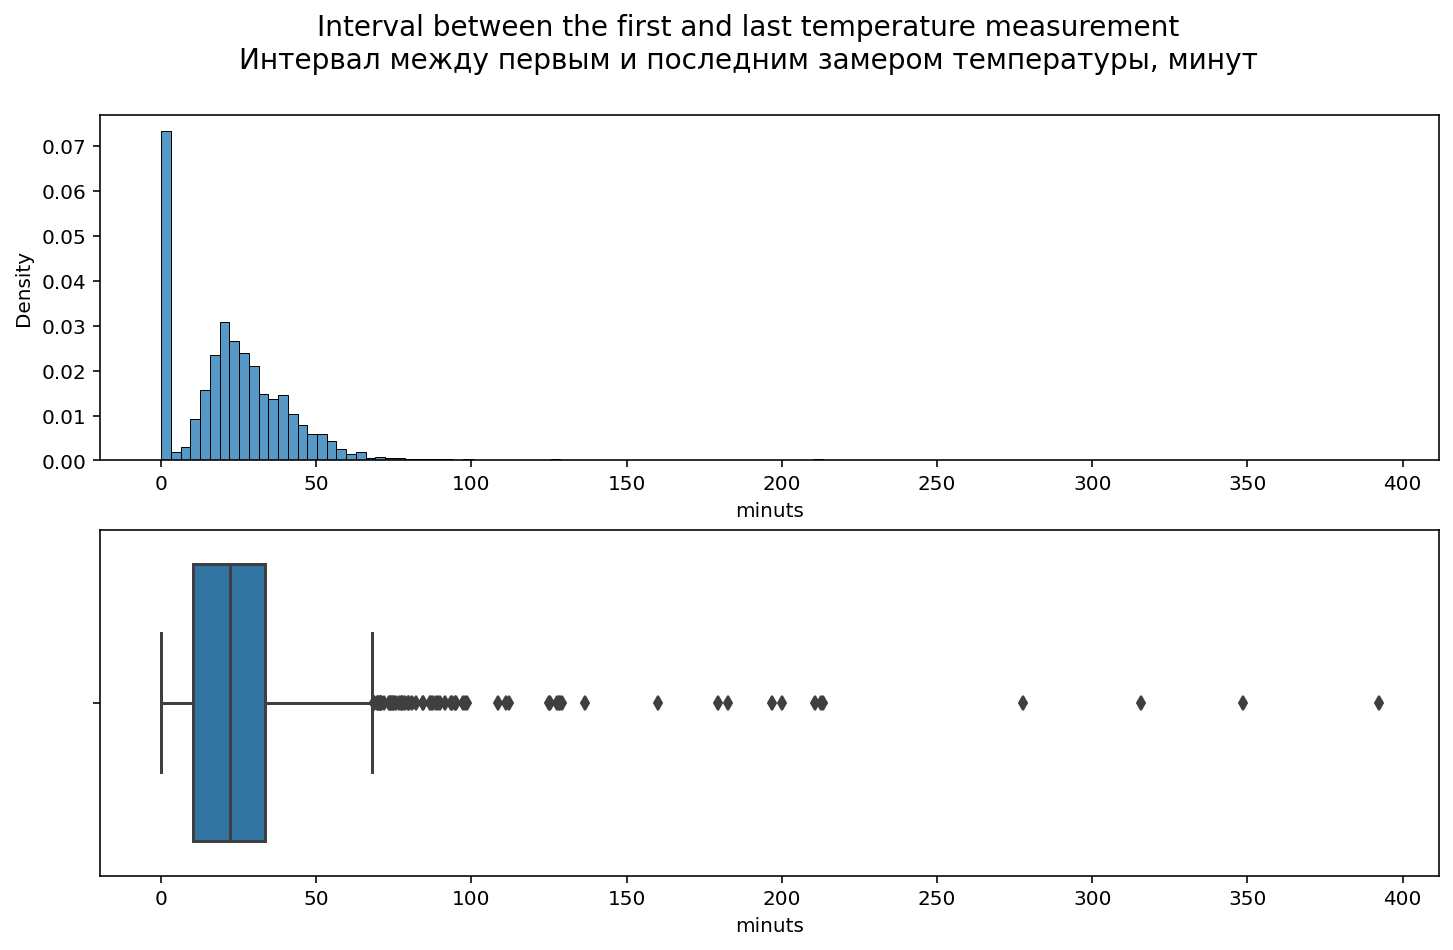

In [10]:
fig = plt.figure(figsize=(12, 7))
plt.suptitle(
    "Interval between the first and last temperature measurement\nИнтервал между первым и последним замером температуры, минут", fontsize=14
)
plt.subplot(2, 1, 1)
sns.histplot(full_data["temp_measure_interval"] / 60, stat="density")
plt.xlabel("minuts")
plt.subplot(2, 1, 2)
sns.boxplot(full_data["temp_measure_interval"] / 60)
plt.xlabel("minuts")
plt.show();

## Conclusions:
- the average value of the interval is 23.8 minutes,
- the median is close to the average, 22 minutes,
- minimum-0 minutes, as you can see from the graph there are many batches for which there is only one measurement, that is, the interval is zero,
- maximum-392 minutes, it looks like an outlier,
- standard deviation-23 minutes, this is a lot, need to deal with outliers.  

## Выводы:
 - среднее значение интервала 23,8 минут,
 - медиана - близка к среднему, 22 минуты,
 - минимальное - 0 минут, как видно из графика много партий, для которых присутсвует только одно измерение, то есть интервал нулевой,
 - максимальное - 392 минуты, похоже на выброс,
 - стандартное отклонение 23 минуты, это очень много, надо разбираться с выбросами.

<a id='22'></a>

## The number of starts of heating by the electrodes. / Количество запусков нагрева электродами.

In [11]:
print("## The number of starts of heating by the electrodes.\nКоличество запусков нагрева электродами\n")
sorted(full_data.arc_count.unique())
full_data.arc_count.describe()

## The number of starts of heating by the electrodes.
Количество запусков нагрева электродами



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: arc_count, dtype: float64

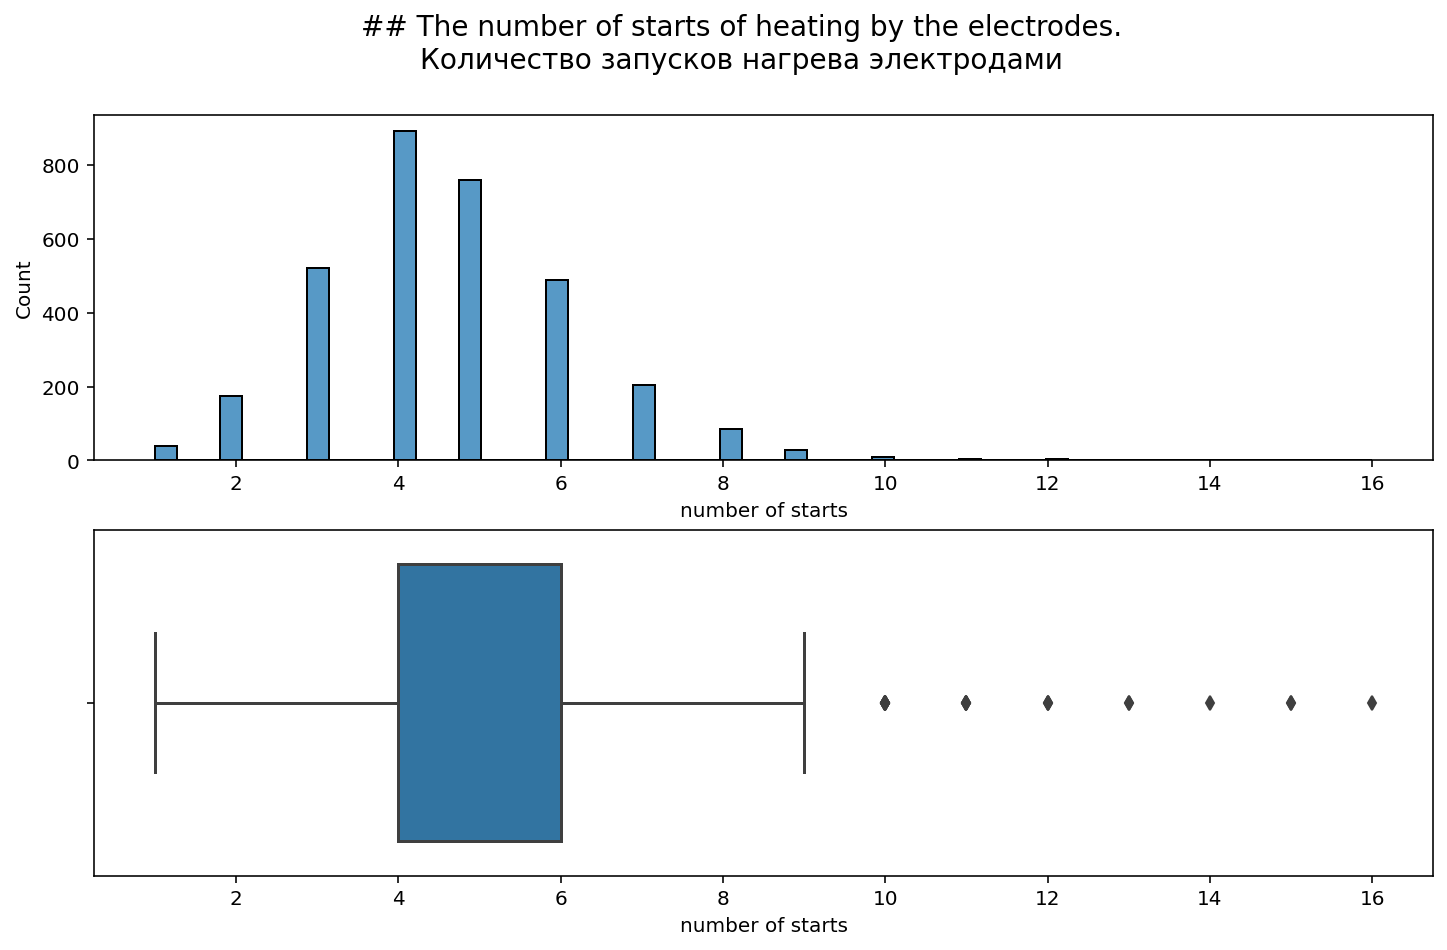

In [12]:
fig = plt.figure(figsize=(12, 7))
plt.suptitle("## The number of starts of heating by the electrodes.\nКоличество запусков нагрева электродами", fontsize=14)
plt.subplot(2, 1, 1)
sns.histplot(full_data["arc_count"])
plt.xlabel("number of starts")
plt.subplot(2, 1, 2)
sns.boxplot(full_data["arc_count"])
plt.xlabel("number of starts")
plt.show();

## Conclusions:
- the average value of the number of starts - 4.63,
- the median - slightly less than the average - 4,
- minimum-1 start,
- maximum - 16, looks like an outlier,
- standard deviation 1.6,
- more than 9 starts are very rare, looks like an outlier,
- distribution looks like normal.  

## Выводы:
 - среднее значение количества запусков - 4,63,
 - медиана - чуть меньше среднего - 4,
 - минимальное - 1 запуск,
 - максимальное - 16, похоже на выброс,
 - стандартное отклонение 1,6,
 - больше 9 запусков встречается очень редко, похоже на выброс,
 - распределение похоже на нормальное.

<a id='2'></a>

## Total electrode heating time / Суммарное время нагрева электродами

In [13]:
full_data["arc_duration"].describe() / 60

count    53.566667
mean     13.242984
std       5.540810
min       0.950000
25%       9.516667
50%      12.833333
75%      16.383333
max      69.816667
Name: arc_duration, dtype: float64

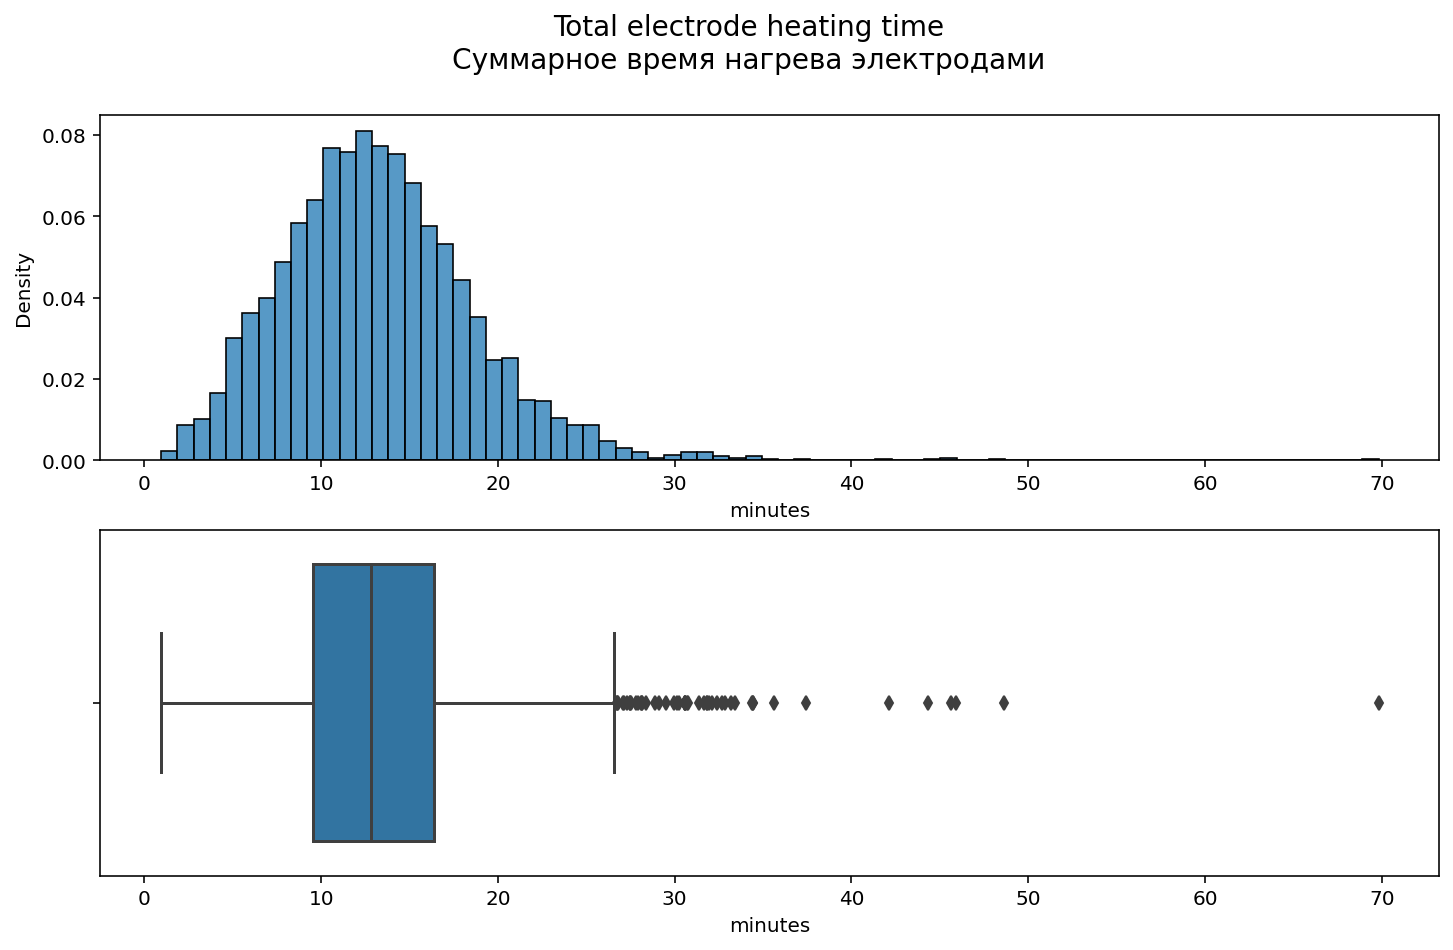

In [14]:
fig = plt.figure(figsize=(12, 7))
plt.suptitle("Total electrode heating time\nCуммарное время нагрева электродами", fontsize=14)
plt.subplot(2, 1, 1)
sns.histplot(full_data["arc_duration"] / 60, stat="density")
plt.xlabel("minutes")
plt.subplot(2, 1, 2)
sns.boxplot(full_data["arc_duration"] / 60)
plt.xlabel("minutes")
plt.show();

## Conclusions:
- average heating time is 13.2 minutes,
- median-close to average, 12.8 minutes,
- minimum-0.95 minutes,
- maximum-69.8 minutes, looks like an outlier,
- standard deviation 5.5 minutes ,
- more than 40 minutes of heating was rarely performed,
- distribution looks like normal.  

## Выводы:
 - среднее значение времени нагрева 13,2 минуты,
 - медиана - близка к среднему, 12,8 минут,
 - минимальное - 0.95 минут,
 - максимальное - 69.8 минут, похоже на выброс,
 - стандартное отклонение 5.5 минут,
 - больше 40 минут нагрев проводился редко,
 - распределение похоже на нормальное.

<a id='4'></a>

## Average ratio of active and reactive power consumption /  Среднее соотношение потребления активной и реактивной мощности

In [15]:
full_data["mean_power_proportion"].describe()

count    3214.000000
mean        1.357545
std         0.132755
min         0.676106
25%         1.292948
50%         1.370596
75%         1.438292
max         1.782164
Name: mean_power_proportion, dtype: float64

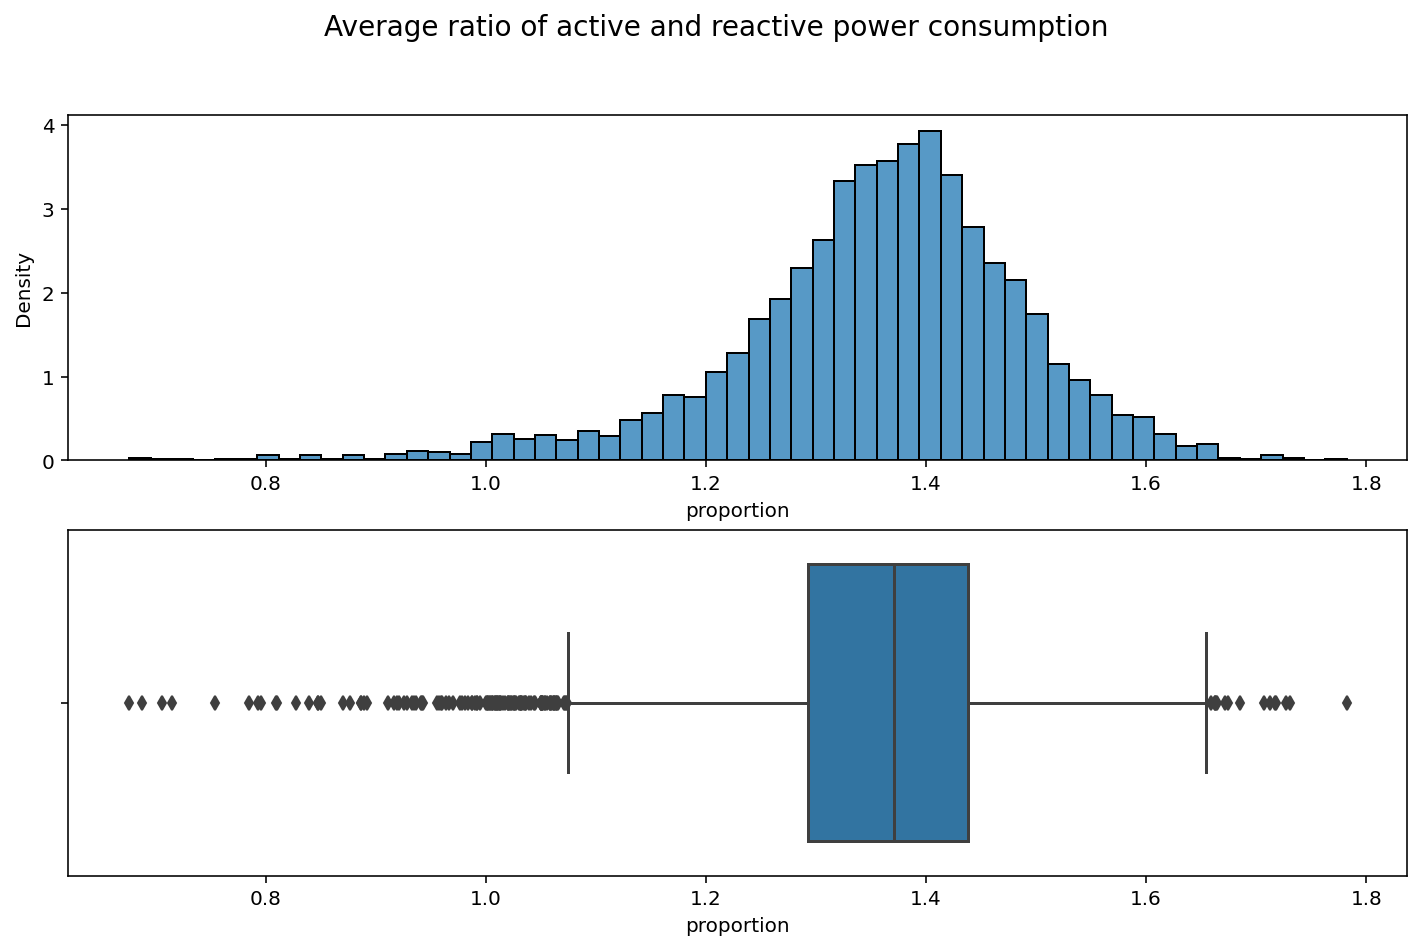

In [16]:
fig = plt.figure(figsize=(12, 7))
plt.suptitle(
    "Average ratio of active and reactive power consumption", fontsize=14
)
plt.subplot(2, 1, 1)
sns.histplot(full_data["mean_power_proportion"], stat="density")
plt.xlabel("proportion")
plt.subplot(2, 1, 2)
sns.boxplot(full_data["mean_power_proportion"])
plt.xlabel("proportion")
plt.show();

## Conclusions:
- the average ratio of active and reactive power is 1.35,
- the median is close to the average, 1.37,
- the minimum ratio is 0.67,
- the maximum is 1.78,
- the standard deviation is 0.13,
- values less than 0.8 are rare,
- the distribution is similar to normal.  

## Выводы:
 - среднее соотношение потребления активной и реактивной мощности - 1.35,
 - медиана - близка к среднему, 1.37,
 - минимальное соотношение - 0.67,
 - максимальное - 1.78,
 - стандартное отклонение 0.13,
 - значения меньше 0.8 встречаются редко,
 - распределение похоже на нормальное.